In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("DN4_1_podatki.csv")
X = data.drop("Q", axis=1)
y = data["Q"]

In [28]:
data

,Q,Tw,Ta,theta,eta
0,1.711929,53.005339,10.788147,0.321921,0.349083
1,0.067135,20.761340,12.225502,2.705824,0.821069
2,0.034759,39.546739,35.892183,1.873776,0.756082
3,0.417783,33.972185,21.385801,2.089589,0.516134
4,1.667614,50.092173,15.254621,0.328350,0.083327
...,...,...,...,...,...
495,1.327393,54.081114,30.039247,1.153132,0.708757
496,0.053967,42.933431,39.799381,1.572222,0.022975
497,0.707523,47.145488,30.707064,2.093919,0.684035
498,0.062350,39.405105,32.647363,0.311168,0.053085


The best equation from the hall of fame is `(square(((2.5343432 - eta) * (Tw - Ta)) * 0.027452817) * sin(theta))`. We attempt to fine tune the coefficients using linear regression

The expression expanded is `0.000753657 η^2 Tw^2 sin(θ) - 0.00382005 η Tw^2 sin(θ) + 0.00484066 Tw^2 sin(θ) - 0.00150731 η^2 Tw Ta sin(θ) + 0.0076401 η Tw Ta sin(θ) - 0.00968132 Tw Ta sin(θ) + 0.000753657 η^2 Ta^2 sin(θ) - 0.00382005 η Ta^2 sin(θ) + 0.00484066 Ta^2 sin(θ)`

With the coefficients as parameters this can be written as `x1 η^2 u^2 sin(θ) + x2 η u^2 sin(θ) + x3 u^2 sin(θ) + x4 η^2 u v sin(θ) + x5 η u v sin(θ) + x6 u v sin(θ) + x7 η^2 v^2 sin(θ) + x8 η v^2 sin(θ) + x9 v^2 sin(θ) = Q`


In [29]:
old_coef = [0.00484066, -0.00382005, 0.00075365, -0.00968132, 0.0076401, -0.00150731, 0.00484066, -0.00382005, 0.000753657]

In [30]:
from math import sin
def add_mult(table, a, b):
    table[a+b] = table[a].to_numpy()*table[b].to_numpy()
    return table
mod = X
mod["sin(theta)"] = mod["theta"].apply(lambda x : sin(x))
mod = add_mult(mod, "Ta", "sin(theta)")
mod = add_mult(mod, "Tw", "sin(theta)")
mod = add_mult(mod, "Ta", "Tasin(theta)") # v² sin
mod = add_mult(mod, "eta", "TaTasin(theta)") # η v² sin
mod = add_mult(mod, "eta", "etaTaTasin(theta)") # η² v² sin
mod = add_mult(mod, "Tw", "Tasin(theta)") # u v sin
mod = add_mult(mod, "eta", "TwTasin(theta)") # η uv sin
mod = add_mult(mod, "eta", "etaTwTasin(theta)") # η² uv sin
mod = add_mult(mod, "Tw", "Twsin(theta)") # u² sin
mod = add_mult(mod, "eta", "TwTwsin(theta)") # η u² sin
mod = add_mult(mod, "eta", "etaTwTwsin(theta)") # η² u² sin
mod = mod.drop("Twsin(theta)", axis=1)
mod = mod.drop("Tasin(theta)", axis=1)
mod = mod.drop("Ta", axis=1)
mod = mod.drop("Tw", axis=1)
mod = mod.drop("theta", axis=1)
mod = mod.drop("eta", axis=1)
mod = mod.drop("sin(theta)", axis=1)

In [31]:
mod

,TaTasin(theta),etaTaTasin(theta),etaetaTaTasin(theta),TwTasin(theta),etaTwTasin(theta),etaetaTwTasin(theta),TwTwsin(theta),etaTwTwsin(theta),etaetaTwTwsin(theta)
0,36.822727,12.854201,4.487188,180.920879,63.156470,22.046873,888.917459,310.306301,108.322769
1,63.089390,51.800720,42.531947,107.138365,87.967952,72.227727,181.942307,149.387123,122.657083
2,1229.571065,929.656027,702.895792,1354.766478,1024.313972,774.464920,1492.709339,1128.610027,853.321246
3,397.173293,204.994509,105.804568,630.925392,325.641838,168.074717,1002.249792,517.294864,266.993296
4,75.042673,6.253083,0.521051,246.420442,20.533484,1.710994,809.180059,67.426572,5.618456
...,...,...,...,...,...,...,...,...,...
495,824.788795,584.574770,414.321416,1484.907262,1052.438304,745.922936,2673.350546,1894.755711,1342.921230
496,1583.989108,36.392109,0.836108,1708.722240,39.257849,0.901948,1843.277634,42.349256,0.972973
497,816.820208,558.733378,382.193026,1254.088850,857.840308,586.792550,1925.440664,1317.068254,900.920406
498,326.332155,17.323183,0.919593,393.880298,20.908943,1.109941,475.410367,25.236927,1.339690


In [32]:
def to_signed_str(number):
    if number < 0:
        return f"{number:.4f}"
    else:
        return f"{number:+.4f}"
    

def linearna_regresija(X, y, meja=1e-2):
    names = list(X.columns.values)
    X = X.to_numpy()
    y = y.to_numpy()
    
    A = np.dot(X.transpose(), X)
    lhs = np.dot(X.transpose(), y)
    b = np.linalg.solve(A, lhs)
    b = map(to_signed_str, list(b))

    eq = np.array(list(zip(b, names))).flatten()
    return ''.join(eq)
linearna_regresija(mod, y)

'+0.0046TaTasin(theta)-0.0024etaTaTasin(theta)-0.0006etaetaTaTasin(theta)-0.0094TwTasin(theta)+0.0059etaTwTasin(theta)+0.0001etaetaTwTasin(theta)+0.0048TwTwsin(theta)-0.0034etaTwTwsin(theta)+0.0004etaetaTwTwsin(theta)'

In [33]:
def linearna_regresija_eval(X, y):
    # Least squares Xb = y
    # returns Xb
    X = X.to_numpy()
    y = y.to_numpy()
    
    A = np.dot(X.transpose(), X)
    lhs = np.dot(X.transpose(), y)
    b = np.linalg.solve(A, lhs)
    return np.dot(X, b)

new_y = linearna_regresija_eval(mod, y)
old_y = np.dot(mod, old_coef)

In [34]:
new_y.shape

(500,)

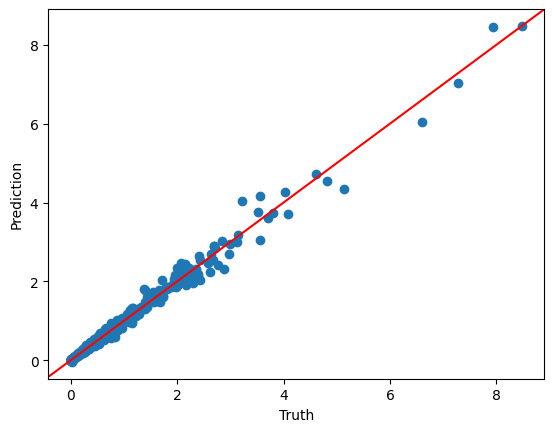

In [35]:
plt.scatter(y, new_y)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.axline((0,0), (1,1), color="red")
plt.show()

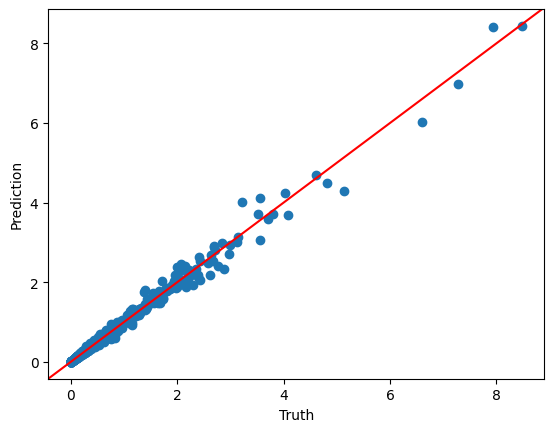

In [36]:
plt.scatter(y, old_y)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.axline((0,0), (1,1), color="red")
plt.show()

Notice that both predictions predictions (genetic and linear regression) give nearly the same results. That loosly implies the coefficients given by PySR are good. We also look at some regularised techniques to avoid overfitting

In [37]:
def ridge_regresija(X, y, lam=1, meja=1e-2):
    X = X.to_numpy()
    A = np.dot(X.transpose(), X)
    A += lam*np.identity(len(A))
    lhs = np.dot(X.transpose(), y)
    b = np.linalg.solve(A, lhs)
    return np.dot(X, b)

from scipy.optimize import minimize

def f(X, y, lam, x):
    inner = np.dot(X, x) - y
    v = inner * inner
    return np.linalg.norm(v, 1) + lam* np.linalg.norm(x, 1)

def lasso_regresija(X, y, lam=1, meja=1e-2):
    X = X.to_numpy()
    y = y.to_numpy()
    partial = lambda x : f(X, y, lam, x)
    x0 = np.zeros(np.shape(X)[1])
    b = minimize(partial, x0)
    b = b["x"]
    return np.dot(X, b)

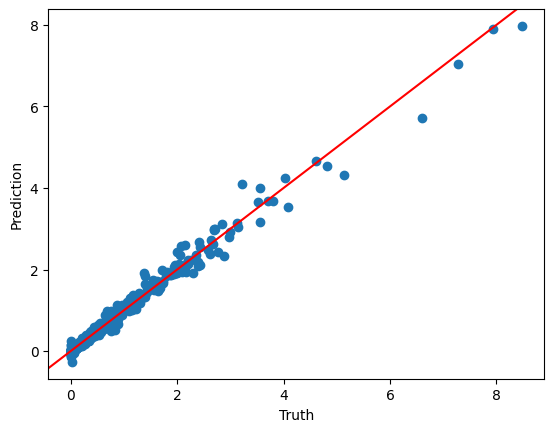

In [38]:
lass_y = lasso_regresija(mod, y, lam=500)
plt.scatter(y, lass_y)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.axline((0,0), (1,1), color="red")
plt.show()

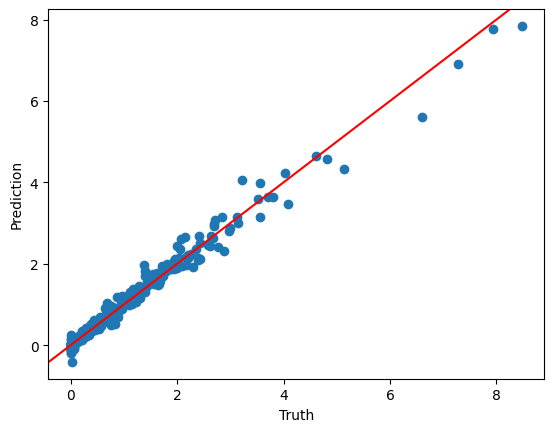

In [50]:
ridge_y = ridge_regresija(mod, y, lam=100000)
plt.scatter(y, ridge_y)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.axline((0,0), (1,1), color="red")
plt.show()

# druga naloga

In [40]:
from make_data import *

@pandise
def first(x1, x2, x3, x4, x5):
    return x1 - 3*x2 - x3 -x5

@pandise
def second(x1, x2):
    return x1**5 * x2**3

@pandise
def third(x1, x2):
    return np.sin(x1) + np.sin(x2 / x1**2)

def dynamic(k):
    return lambda x: (np.tanh(-np.log2(x)/k)+1)/2

def adaptive_dynamic(start, end, slope):
    return lambda i: dynamic(max(-i/slope+start, end))

def constant(k):
    return lambda i: (lambda x: k)

def inv_pow(k):
    return lambda i: (lambda x: (1/(x+1))**k)

In [74]:
import csv
# aux functions to help with plotting

def write(function, sz, arr):
    with open(str(function)+str(sz)+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(arr)

def read(filename):
    def tofloat(l):
        return list(map(float, l))
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        data = list(map(tofloat,reader))
    return data

def maxcols(arr):
    return len(max(arr, key=lambda x: len(x)))

def pad(arr, longest):
    temp = []
    for attempt in arr:
        temp.append(attempt + [0]*(longest-len(attempt)))
    return temp

def average(arr):
    # would be nice to broadcast
    from statistics import mean
    temp = []
    for i in range(len(arr[0])):
        temp.append(mean([arr[j][i] for j in range(len(arr))]))
    return temp

def make_x(arr, batch_size):
    return [batch_size*i for i in range(1,len(arr)+1)]

def prepare_plot(file):
    lame = {"firstdum1000.csv":1000, "firstdum4000.csv":4000, "firstgen1000.csv": 1000,
            "seconddum4000.csv": 4000, "sndgen1000.csv":1000, "trdgen300.csv":300, "thirddum6000.csv":6000}
    batch_size = lame[file]
    arr = read(file)
    longest = maxcols(arr)
    arr = pad(arr, longest)
    arr = average(arr)
    return (make_x(arr, batch_size), arr)

Text(0, 0.5, 'Napaka')

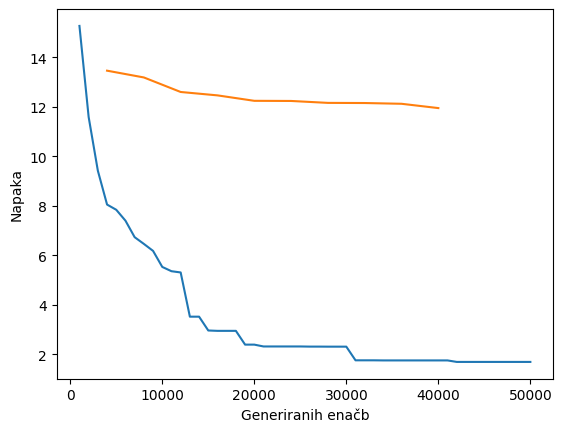

In [70]:
plt.plot(*prepare_plot("firstgen1000.csv"))
plt.plot(*prepare_plot("firstdum4000.csv"))
plt.xlabel('Generiranih enačb')
plt.ylabel('Napaka')

Text(0, 0.5, 'Napaka')

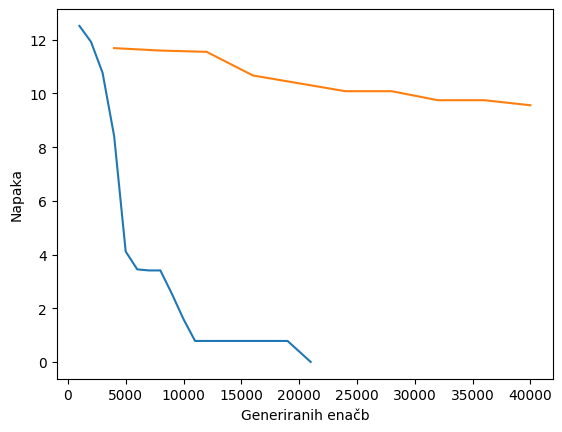

In [71]:
plt.plot(*prepare_plot("sndgen1000.csv"))
plt.plot(*prepare_plot("seconddum4000.csv"))
plt.xlabel('Generiranih enačb')
plt.ylabel('Napaka')

Text(0, 0.5, 'Napaka')

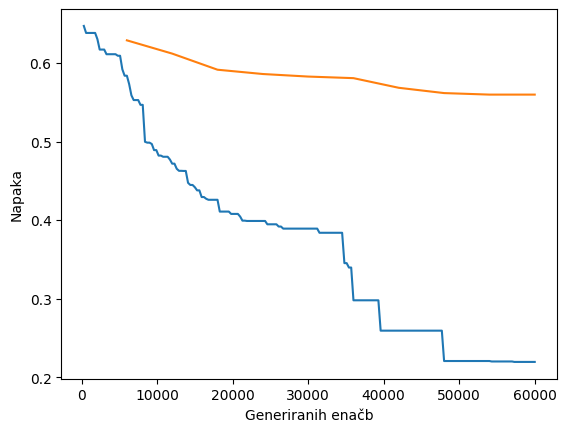

In [75]:
plt.plot(*prepare_plot("trdgen300.csv"))
plt.plot(*prepare_plot("thirddum6000.csv"))
plt.xlabel('Generiranih enačb')
plt.ylabel('Napaka')